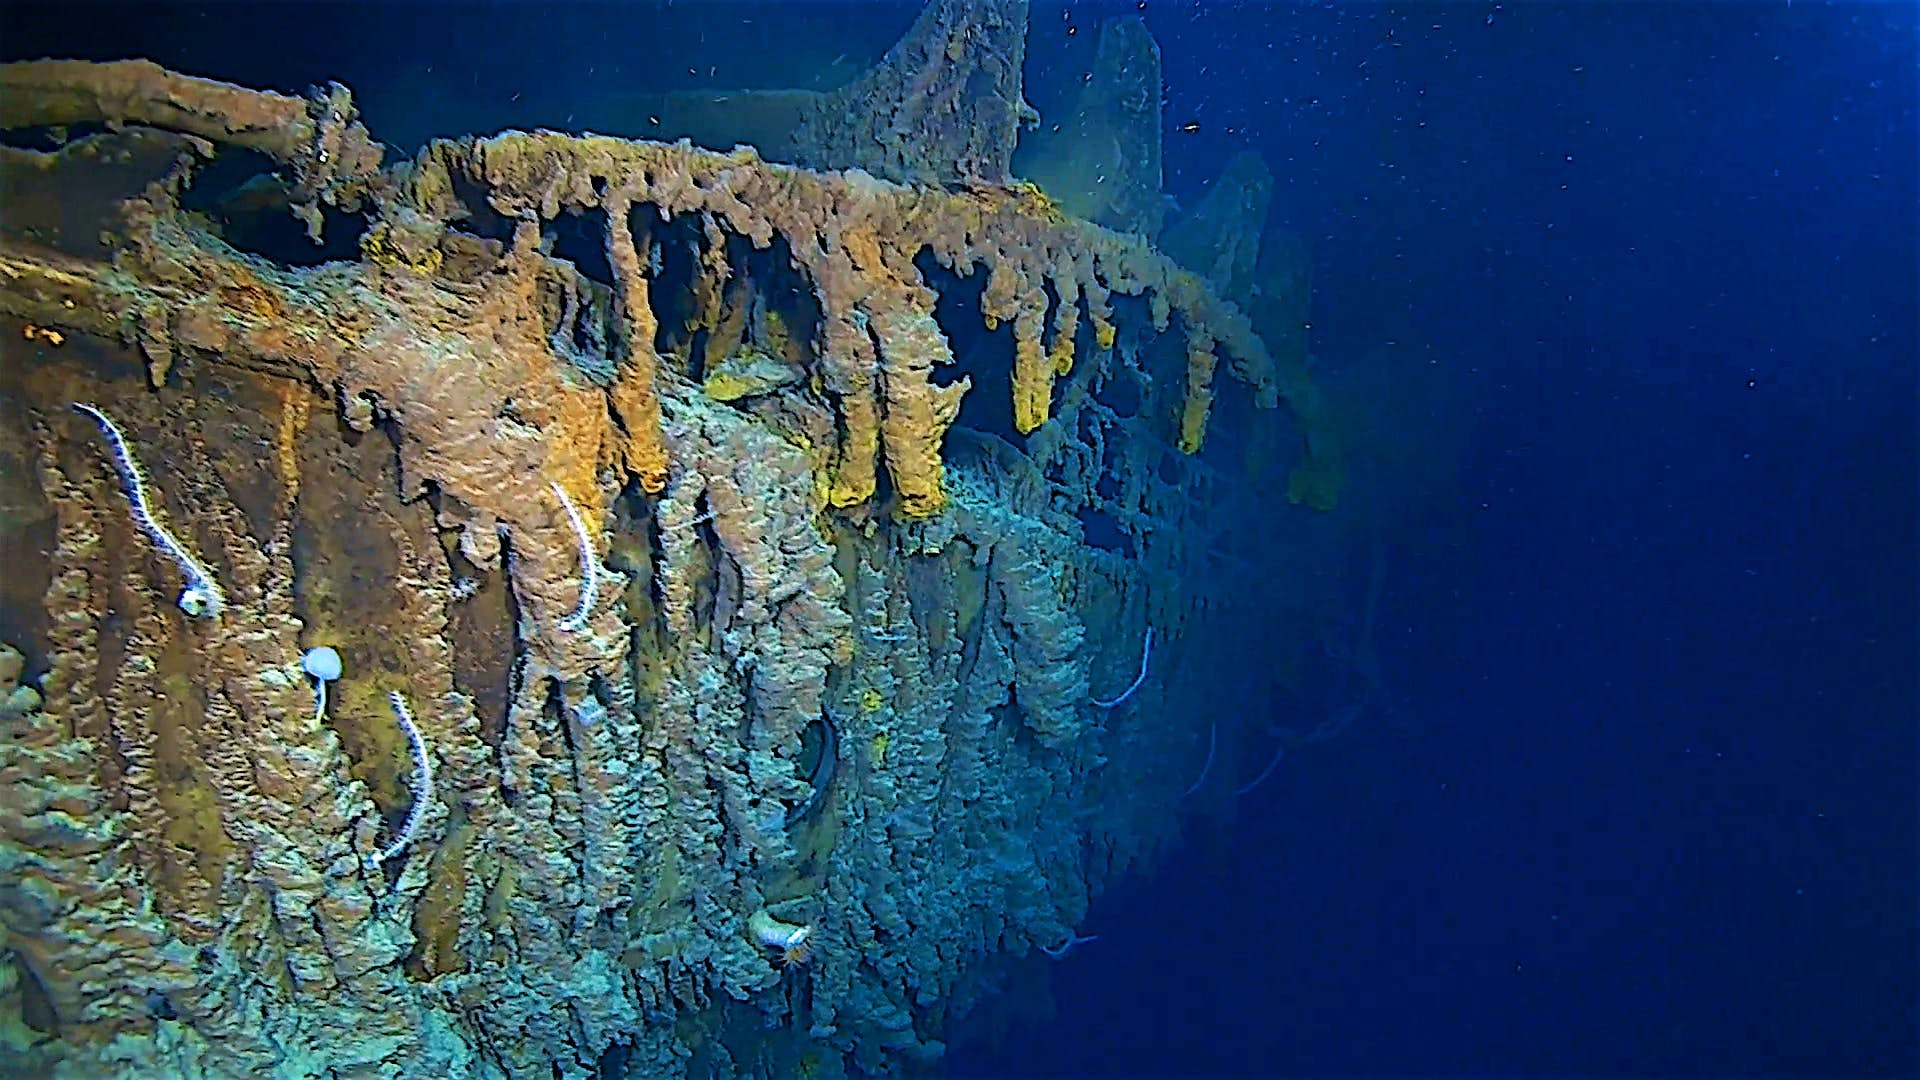

### **The Challenge**

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Recommended Tutorial
We highly recommend Alexis Cook’s Titanic Tutorial that walks you through making your very first submission step by step.


### **What Data Will I Use in This Competition?**

In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.



### **Goal**

It is your job to predict if a passenger survived the sinking of the Titanic or not. 
For each in the test set, you must predict a 0 or 1 value for the variable.

### **Metric**

Your score is the percentage of passengers you correctly predict. This is known as accuracy.

### **Submission File Format**

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

* PassengerId (sorted in any order)
* Survived (contains your binary predictions: 1 for survived, 0 for deceased)

> PassengerId,Survived

> 892,0

> 893,1

> 894,0

> Etc.

### **Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
sns.set_theme()

In [ ]:
train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")

In [ ]:
train_df.head()

In [ ]:
print("Number of rows present in the dataset    :{}".format(train_df.shape[0]))
print("Number of columns present in the dataset :{}".format(train_df.shape[1]))

In [ ]:
train_df.info()

In [ ]:
train_df.drop("Cabin", axis = 1, inplace = True)

In [ ]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace = True)

In [ ]:
train_df[train_df.isna().any(axis=1)]

In [ ]:
train_df.dropna(inplace=True)
train_df.duplicated().sum()

In [ ]:
train_df.head()

In [ ]:
train_df.columns

In [ ]:
train_df = train_df[['Survived','Pclass','Sex','Age',
                      'SibSp','Parch','Fare','Embarked']]
dummies = pd.get_dummies(train_df[["Sex","Embarked"]])
df = pd.concat([train_df,dummies], axis=1)
df.drop(["Sex","Embarked"], axis=1, inplace=True)
df.head()

In [ ]:
print("Number of rows present in a dataset after preprocessing     :{}".format(df.shape[0]))
print("Number of columns present in a dataset after preprocessing  :{}".format(df.shape[1]))

In [ ]:
df.describe()

In [ ]:
correlate = df.corr()
correlate["Survived"]

In [ ]:
df[["Pclass","Age","Fare","Sex_female",
    "Sex_male","Embarked_C","Embarked_Q",
    "Embarked_Q"]].hist(bins=50, figsize = (20,15))
plt.show()

In [ ]:
def diag_plots(data,variable):
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    sns.distplot(data[variable], bins = 15)
    
    plt.subplot(1,2,2)
    stats.probplot(data[variable], dist = "norm", plot = plt)
    
    plt.show()
    

In [ ]:
diag_plots(df, "Age")

In [ ]:
diag_plots(df, "Fare")

In [ ]:
#Logarithmic Transformation on Fare
df["Log_Fare"] = np.log(df["Fare"]+1) # adding +1 because if there are any zero's, we can't perform log on zero's
diag_plots(df, "Log_Fare")

In [ ]:
#Reciprocal Transformation
df["Rec_Fare"] = 1/(df["Fare"]+1)
diag_plots(df, "Rec_Fare")

In [ ]:
#Square Root Transformation
df["Sqrt_Fare"] = df["Fare"]**(1/2)
diag_plots(df, "Sqrt_Fare")

In [ ]:
#Square Root Transformation
df["Exp_Fare"] = df["Fare"]**(1/5)
diag_plots(df, "Exp_Fare")

In [ ]:
#Box cox
df["bc_fare"], param = stats.boxcox(df.Fare+1)
print("Optimal Lambda Param: {}".format(param))
diag_plots(df, "bc_fare")

In [ ]:
df.columns

In [ ]:
X = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Log_Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = df["Survived"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

### **LOGISTIC REGRESSION**

In [ ]:
Log_class = LogisticRegression()
Log_class.fit(x_train,y_train)
predict_log = Log_class.predict(x_test)
predict_log

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eval(y_test, predict):
    print(
        "accuracy              :\n\n{}".format(accuracy_score(y_test, predict)), 
        "\n\nconfusion matrix      :\n\n{}".format(confusion_matrix(y_test, predict)), 
        "\n\nclassification report :\n\n{}".format(classification_report(y_test, predict))
    )

In [ ]:
eval(y_test, predict_log)

### **STOCHASTIC GRADIENT DESCENT**

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(x_train,y_train)
predict_sgd = sgd_clf.predict(x_test)

predict_sgd

In [ ]:
eval(y_test, predict_sgd)

### **DECISION TREE CLASSIFIER**

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth = 11)
dt_clf.fit(x_train, y_train)
predict_dtc = dt_clf.predict(x_test)
predict_dtc

In [ ]:
eval(y_test, predict_dtc)

### **RANDOM FOREST CLASSIFIER**

In [ ]:
rfc_clf = RandomForestClassifier(max_depth = 12, min_samples_split = 6, random_state = 0)
rfc_clf.fit(x_train,y_train)
predict_rfc = rfc_clf.predict(x_test)
predict_rfc

In [ ]:
eval(y_test, predict_rfc)

In [ ]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'min_samples_split': [8, 10, 12]
}

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator = rf_clf, 
                           param_grid = param_grid, 
                           cv=3, 
                           n_jobs = -1, 
                           verbose = 2)
grid_search.fit(x_train,y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_estimator_

### **ADA BOOST CLASSIFIER**

In [ ]:
ada_clf = AdaBoostClassifier().fit(x_train,y_train)
predict_abc = ada_clf.predict(x_test)
predict_abc

In [ ]:
eval(y_test, predict_abc)

In [ ]:
ab_clf = AdaBoostClassifier()
ab_clf.get_params()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ab_clf, x_train, y_train, 
                           scoring='accuracy', cv=cv, 
                           n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
AdaBoostClassifier().get_params()

### **CATBOOST CLASSIFIER**

In [ ]:
cb_clf = CatBoostClassifier(task_type = "GPU", 
                            eval_metric = 'Accuracy', 
                            iterations = 1000, 
                            random_state=0
                           )
cb_clf.fit(x_train,y_train)
predict_cbc = cb_clf.predict(x_test)
predict_cbc

In [ ]:
eval(y_test,predict_cbc)

In [ ]:
cb_clf.get_params()

In [ ]:
param_grid = {
    'iterations': [250,500,750,1000,1500],
    'task_type': ["GPU"],
    'random_state': [0]
}

In [ ]:
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = CatBoostClassifier()
parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100)
             }
    
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(x_train, y_train)

# Results from Random Search
print("========================================================")
print(" Results from Random Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
      randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("========================================================")

In [ ]:
predict_rcbc = randm.predict(x_test)
eval(y_test, predict_rcbc)

### **XGBOOST CLASSIFIER**

In [ ]:
from xgboost import XGBClassifier
XGBClassifier()

In [ ]:
xgb = XGBClassifier(max_depth=5, n_estimators = 40).fit(x_train, y_train)
predict_xgbc = xgb.predict(x_test)
eval(y_test,predict_xgbc)

In [ ]:
pred = [predict_log,predict_sgd,predict_dtc,predict_rfc,predict_abc,predict_cbc,predict_rcbc,predict_xgbc]
pred

In [ ]:
print("|==================================================================|\n")
print("  The ACCURACY OF LogisticRegression is     |  {}\n".format(accuracy_score(y_test,predict_log)))
print("|==================================================================|\n")
print("  The ACCURACY OF SGDClassifier is          |  {}\n".format(accuracy_score(y_test,predict_sgd)))
print("|==================================================================|\n")
print("  The ACCURACY OF DecisionTreeClassifier is |  {}\n".format(accuracy_score(y_test,predict_dtc)))
print("|==================================================================|\n")
print("  The ACCURACY OF RandomForestClassifier is |  {}\n".format(accuracy_score(y_test,predict_rfc)))
print("|==================================================================|\n")
print("  The ACCURACY OF AdaBoostClassifier is     |  {}\n".format(accuracy_score(y_test,predict_abc)))
print("|==================================================================|\n")
print("  The ACCURACY OF CatBoostClassifier is     |  {}\n".format(accuracy_score(y_test,predict_rcbc)))
print("|==================================================================|\n")
print("  The ACCURACY OF XGBoostClassifier is      |  {}\n".format(accuracy_score(y_test,predict_xgbc)))
print("|==================================================================|\n")

In [ ]:
test_df = pd.read_csv("../input/titanic/test.csv")

In [ ]:
test_df.head()

In [ ]:
test_df.info()

In [ ]:
test_df.drop("Cabin", axis=1, inplace=True)

In [ ]:
test_df["Age"].fillna(train_df["Age"].mean(), inplace = True)
test_df["Fare"].fillna(test_df["Fare"].mean(), inplace = True)

In [ ]:
passenger_id = test_df["PassengerId"]
df = test_df[['Pclass','Sex','Age',
              'SibSp','Parch','Fare','Embarked']]

In [ ]:
x = df
x.head()

In [ ]:
dummies = pd.get_dummies(x[["Sex","Embarked"]])
data = pd.concat([df, dummies], axis=1)
data.drop(["Sex","Embarked"], axis=1, inplace=True)
data.head()

In [ ]:
prediction = rfc_clf.predict(data)
prediction

In [ ]:
output = pd.DataFrame({'PassengerId': passenger_id, 'Survived': prediction.astype(int)})
output

In [ ]:
output.to_csv('submission1.csv', index=False)